In [25]:
%matplotlib inline

import geopandas
import geoplot
import mapclassify

In [26]:
world = geopandas.read_file(
    geopandas.datasets.get_path('naturalearth_lowres')
)

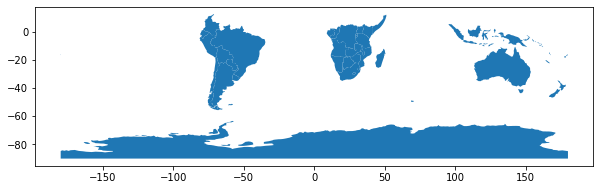

In [14]:
southern_world = world.cx[:, :0]
southern_world.plot(figsize=(10, 3));

In [40]:
norge = world.query('name == "Norway"')

In [38]:

geoplot.polyplot(norge, edgecolor='gray', ax=ax)

##

#geoplot.polyplot(africa, edgecolor='gray', ax=ax)

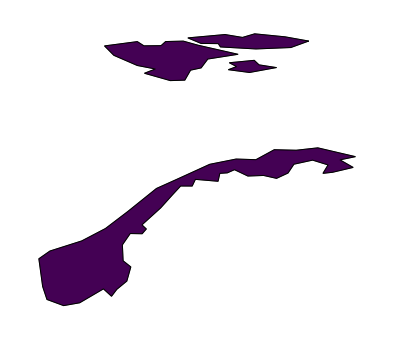

In [41]:
ax = geoplot.choropleth(norge, hue='pop_est')
geoplot.polyplot(norge, edgecolor='gray', ax=ax)

In [42]:
import shapefile as shp

In [43]:
shp_path = './shape/no_1km.shp'
sf = shp.Reader(shp_path)

In [45]:
len(sf.shapes())

2244264

In [49]:
gdf = geopandas.read_file('./shape/no_10km.shp')

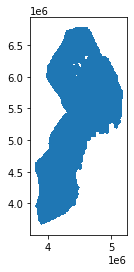

In [50]:
gdf.plot()